# Figure 9: probability of each possible sequence of observed neighbourhood infections

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [2]:
%matplotlib inline
import time
import numpy as np
import pylab as plt
import random
import multiprocessing as mp
import itertools
from scipy.optimize import fsolve
from numpy import unique
from numpy import where
from sklearn.cluster import Birch
import pandas as pd

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_model_6neigh
import R_star_construct

importlib.reload(Gillespie_household_model_6neigh)
importlib.reload(R_star_construct)

do_Gillespie = Gillespie_household_model_6neigh.do_Gillespie
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2,h3,h4,h5,h6 = 2520,2520,1260,1260,840,840      # no. of households in each neighbourhood
n1,n2,n3,n4,n5,n6 = 2,2,4,4,6,6                      # size of households for each neighbourhood
N_neigh = 6

gamma = 0.2                                                 # recovery rate from infection
days = 100                                                  # no. of days in simulation
tStart, tEnd = 0, days                                      # start time and end time (days) of simulation

time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000

H = np.array([h1,h2,h3,h4,h5,h6])
N = np.array([n1,n2,n3,n4,n5,n6])

In [4]:
nu = 3      # good range 1 to 6   # change this for supplementary results
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu

alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Running the sims for $6$ neighbourhoods

In [5]:
alpha_vec = np.zeros(chains, dtype=object) # intialising array to store each set of alpha values
                                           # we simulate proportion of contacts reserved for ones own 
for chain in range(chains):                # neighbourhood each run  

    p_weak = np.random.uniform(0.4,0.5,1)[0] # realisation of r for weakly connected neighbourhoods
    p_strong = np.random.uniform(0,0.1,1)[0] # realisation of r for strongly connected neighbourhoods

    p_reserve = np.array([p_strong,p_weak,p_strong,p_weak,p_strong,p_weak])
    rho = np.zeros((N_neigh,N_neigh))

    for i in range(N_neigh):   # using the r values to calculate the rho values
        for j in range(N_neigh):
            rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
        rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))
    alpha_vec[chain] = alpha*rho   # saving all 'alpha' vectors for each simulation run

t = time.process_time()                # recording how long takes to run
pool = mp.Pool(mp.cpu_count())         # starting paralellisation

Infs = np.zeros(N_neigh)
Infs[0] = 1                   # not actually needed just left in code atm

params_dict = {'beta': [beta,beta,beta,beta,beta,beta],                      # parameter dictionary inputted into SSA
               #'alpha': alpha, # this is different for each run now
               'gamma':gamma,
               'n': N, 
               'h': H,
               'inf0': Infs,
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
# we create a seperate dictionary containing the alpha values for each run and then merge the 2 together    
neigh6_results7 = pool.map(do_Gillespie, [{**params_dict,**{'alpha': alpha_vec[i]}} for i in range(chains)])
   
pool.close()                                   # end parallelisation
elapsed_time = time.process_time() - t         # time taken to run sims
print("elapsed time: ", elapsed_time)    

elapsed time:  2.734375


### Unpacking the results and finding the probability of each sequence of observed infections occurring

In [6]:
obs_outbreak7 = 7*np.ones((chains,N_neigh))   # initialise array for first neighbourhood observed outbreak

for i in range(chains):                          # unpacking results
    if len(neigh6_results7[i][0]) == N_neigh:
        obs_outbreak7[i,:] = neigh6_results7[i][0]
        
seq_out = obs_outbreak7[~np.all(obs_outbreak7 == 7, axis=1)] # removing runs that didn't take off

seqs_out = np.zeros((len(seq_out),N_neigh),dtype=int)   # ensuring neighbourhood infection sequences represented as 
seqs_out[:] = seq_out                                   # integers not floats 

neighs = np.arange(0,6,1)                       # creating array of all the possible neighbourhood infection
seqs = list(itertools.permutations(neighs,6))   # sequences

seq_count = np.zeros(len(seqs))     # recording how many times each possible sequence of neighbourhoods occurs
for i in range(len(seqs)):
    seq_count[i] = np.count_nonzero(np.count_nonzero(seq_out == seqs[i],axis=1) == N_neigh)

In [7]:
#### let's save the data
#np.savetxt('seq_count_nu5.csv', seq_count, delimiter=',')
#np.savetxt('number_of_outbreaks_nu5.csv', [len(seq_out)], delimiter=',')

### Producing figure

Text(0.5, 1.0, '$\\nu=$3, $n=$[2 2 4 4 6 6], $r=[U(0,0.1),U(0.4,0.5)]$')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


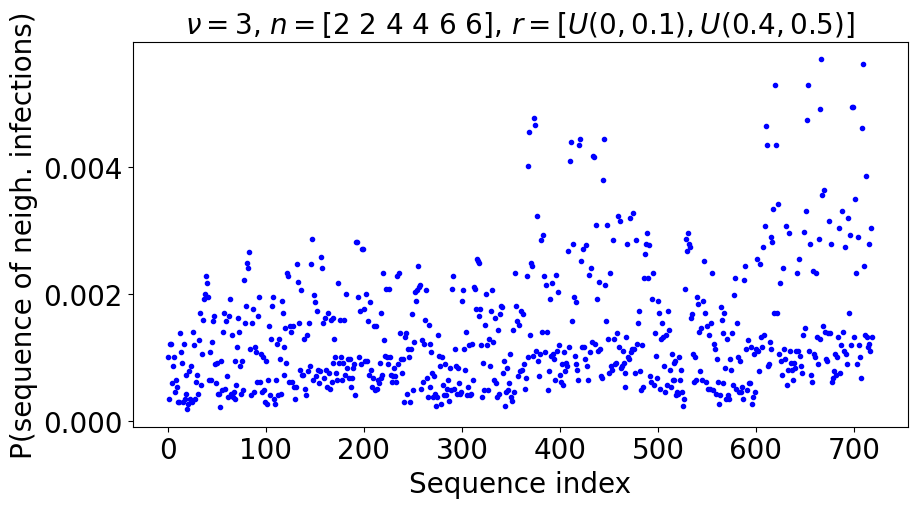

In [8]:
# plotting the proportion of times each sequence of neighbourhoods occurs
figure = plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})

plt.plot(np.arange(0,len(seqs),1),seq_count/len(seq_out),'.',color='blue')
plt.ylabel('P(sequence of neigh. infections)', color='black', fontsize=20)
plt.xlabel('Sequence index', color='black', fontsize=20)
#plt.axhline(0.22, color='black', ls='--')
#plt.axhline(0.09, color='black', ls='--')
plt.grid(False)
plt.xticks(color='black', fontsize=20)
plt.yticks(color='black', fontsize=20)
#plt.title(r'$r=${},$\nu=${}'.format(p_reserve,nu))
plt.title(r'$\nu=${}, $n=${}, $r=[U(0,0.1),U(0.4,0.5)]$'.format(nu,N,p_reserve), color='black', fontsize=20)
#plt.savefig('all_seqences_50k_nu5_range.pdf', bbox_inches='tight')

In [10]:
# this will need changing to your file path, I include this here so I don't have to keep running the above code
file_path = 'C:/Users/abby2/Documents/SAMBa/Demographic clustering project/Publication_results/seq_count.csv'
file_path2 = 'C:/Users/abby2/Documents/SAMBa/Demographic clustering project/Publication_results/number_of_outbreaks.csv'

neighs = np.arange(0,6,1)                       # creating array of all the possible neighbourhood infection
seqs = list(itertools.permutations(neighs,6))   # sequences
# Load the data from the CSV file into a pandas DataFrame
seq_count_nu = pd.read_csv(file_path, header=None)
number_of_outbreaks = pd.read_csv(file_path2, header=None)
num_out = number_of_outbreaks.iloc[:, 0][0]
seq_counts_nu = np.zeros(len(seqs))
seq_counts_nu[:] = seq_count_nu.iloc[:, 0]    # reformat as an array

data = np.zeros((len(seqs),len(seqs)))
data[:,1] = seq_counts_nu/num_out
data[:,0] = np.arange(0,len(seqs),1)

y_coordinates = data[:, 1].reshape(-1, 1)

### Producing figure with clustering analysis

In [11]:
## producing figure for nu=3 first

Text(0, 0.5, 'P(sequence neigh. infections)')

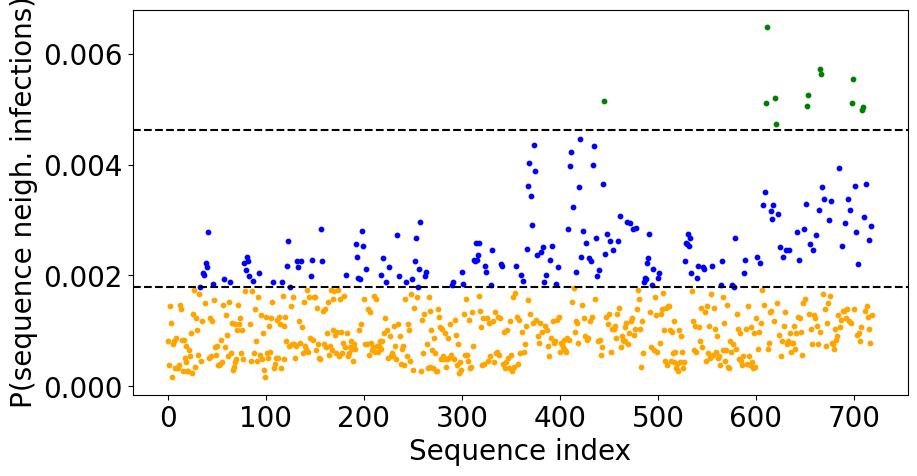

In [12]:
figure = plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})

model = Birch(threshold=0.00005, n_clusters=3)  #0.0001
col_vec = ['blue', 'orange', 'green']
# fit the model
model.fit(y_coordinates)
# assign a cluster to each example
yhat = model.predict(y_coordinates)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
 # create scatter of these samples
    plt.scatter(data[row_ix, 0], data[row_ix, 1],s=10, color=col_vec[cluster])
# show the plot

plt.axhline(0.0018, color='black', ls='--')
plt.axhline(170/num_out, color='black', ls='--')
plt.xticks(color='black', fontsize=20)
plt.yticks(color='black', fontsize=20)
plt.xlabel('Sequence index', color='black', fontsize=20)
plt.ylabel('P(sequence neigh. infections)', color='black', fontsize=20)

#plt.show()
#plt.savefig('all_seqences_nu3.pdf', bbox_inches='tight')

Note: you may need to fiddle around with some parameters to get the correct fit.

We now find the top 6.9% of sequences as determined by the higher cut-off found using the clustering algorithm. We record the data to use in the next result.

In [13]:
top_seq = 0 # initialise counter
top_69 = int(sum(seq_counts_nu)*0.069)  # calculate how many outbreaks in the top 6.9% 

# sort indices of seq_counts_nu so they are in decreasing order of how many times each sequence occurs
indices_ordered = np.argsort(seq_counts_nu)[::-1]

for i in range(len(seq_counts_nu)):    # loop over all sequences that occur
    top_seq += seq_counts_nu[indices_ordered[i]]   # add next top sequenace no. of outbreaks to counter
    if top_seq >= top_69:       # if have atleast reached how many outbreaks occur in top 6.9%
        count = i               # record index of last sequence included (in reordered set)
        diff = 0                # initialise difference counter
        if top_seq > top_69:        # if not all outbreaks in last sequence included counted in top 6.9%
            diff = top_seq - top_69    # record difference
        break

top_seqs = []   # initialise array to record each sequence instance that occurs in the top 6.9%
               
for j in range(count-1):   # loop over sequences that occur in the top 6.9% (except last one)
    for k in range(int(seq_counts_nu[indices_ordered[j]])): # loop over the no. of times each sequence occurs                     
        top_seqs.append(seqs[indices_ordered[j]])   # append sequence to top seqs                          

### need to add in last entries of diff 
for l in range(int(diff)):  # loop over no. of times last sequence occurs (might not be the complete no. of times)
    top_seqs.append(seqs[indices_ordered[count-1]])   # append to top seqs                              

In [14]:
# saving the data
#np.savetxt('top_count.csv', top_count, delimiter=',')
#np.savetxt('top_seqs_nu1.csv', top_seqs, delimiter=',')

Appendix figures D1 found simply by changing $\nu$. But we use the same cutoffs as $\nu=3$ for comparison. Run this piece of code after changing $\nu$.

(0.0, 0.006)

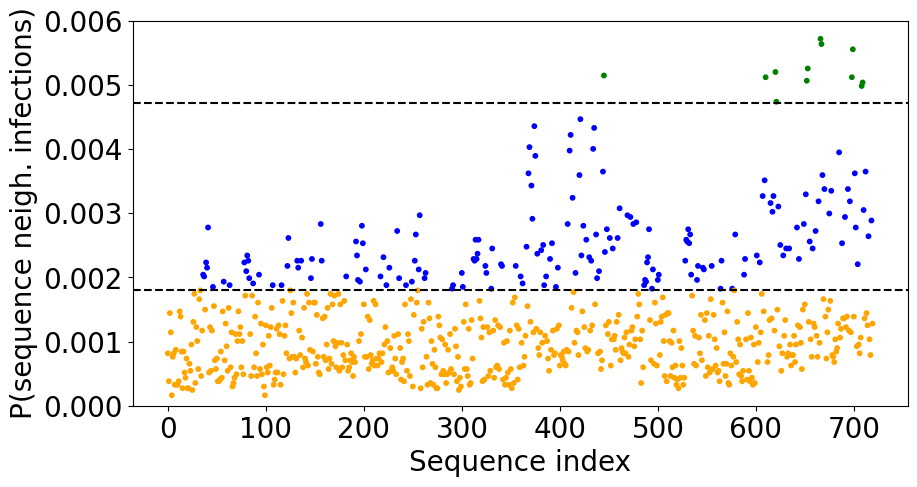

In [15]:
figure = plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 20})

y=data[:, 1]
line1_value = 0.0018
line2_value = 173/num_out 
colors = np.select([y < line1_value, (y >= line1_value) & (y <= line2_value), y > line2_value],
                   ['orange', 'blue', 'green'], default='black')
plt.scatter(data[:, 0], data[:, 1],s=10, color=colors)
# show the plot
#plt.axhline(0.0035, color='black', ls='--')
plt.axhline(line1_value, color='black', ls='--')
plt.axhline(line2_value, color='black', ls='--')
plt.xticks(color='black', fontsize=20)
plt.yticks(color='black', fontsize=20)
plt.xlabel('Sequence index', color='black', fontsize=20)
plt.ylabel('P(sequence neigh. infections)', color='black', fontsize=20)

#plt.show()
plt.ylim(0,0.006)
